# Imports

In [2]:
import numpy as np
from typing import Callable
from collections import namedtuple
import matplotlib.pyplot as plt
import random
import networkx as nx
import seaborn as sns
from itertools import product

# Task 1

## Define class for perceptron

In [383]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class Perceptron:
    """
    Perceptron classifier

    Parameters
    ----------
    num_inputs : int
        The number of inputs

    Attributes
    ----------
    weights : numpy.ndarray
        The weights of the perceptron
    """
    def __init__(self, num_inputs: int):
        """
        Initialize the weights of the perceptron

        Parameters
        ----------
        num_inputs : int
            The number of inputs
        """
        self.weights = np.zeros(num_inputs + 1)

    def predict(self, inputs: np.ndarray) -> np.ndarray:
        """
        Predict the output of the perceptron

        Parameters
        ----------
        inputs : numpy.ndarray
            The inputs to the perceptron

        Returns
        -------
        int
            The output of the perceptron
        """
        weighted_sum = np.dot(inputs, self.weights[1:]) + self.weights[0]
        return sigmoid(weighted_sum)

    def train(self, inputs: np.ndarray, labels: np.ndarray, learning_rate: float = 0.1, epochs: int = 1000):
        """
        Train the perceptron

        Parameters
        ----------
        inputs : numpy.ndarray
            The inputs to the perceptron
        labels : numpy.ndarray
            The labels of the inputs
        learning_rate : float
            The learning rate of the perceptron
        epochs : int
            The number of epochs to train the perceptron
        """
        for _ in range(epochs):
            for input_vec, label in zip(inputs, labels):
                prediction = self.predict(input_vec)
                error = label - prediction
                self.weights[1:] += learning_rate * error * input_vec
                self.weights[0] += learning_rate * error


## Make factories for boolean functions: not, and, or, xor, eq, two_equal
### Each factory creates a perceptron and a data set to train the perceptron for the corresponding task
### The two_equal function returns true if and only if two of the three variables are equivalent and the third is different

In [384]:
Predictor = Callable[[int], float]

def not_factory() -> Predictor:
    p = Perceptron(1)
    p.train(np.array([[1], [0]]), np.array([0, 1]))
    return lambda x: np.rint(p.predict([x]))


def and_factory() -> Predictor:
    p = Perceptron(2)
    p.train(np.array([[1, 1], [1, 0], [0, 1], [0, 0]]), np.array([1, 0, 0, 0]))
    return lambda x1, x2: np.rint(p.predict([x1, x2]))

def or_factory() -> Predictor:
    p = Perceptron(2)
    p.train(np.array([[1, 1], [1, 0], [0, 1], [0, 0]]), np.array([1, 1, 1, 0]))
    return lambda x1, x2: np.rint(p.predict([x1, x2]))

def xor_factory(
    *,
    NOT: Predictor = None,
    AND: Predictor = None,
    OR: Predictor = None
) -> Predictor:
    NOT = NOT if NOT else not_factory()
    AND = AND if AND else and_factory()
    OR = OR if OR else or_factory()
    return lambda x1, x2: AND(NOT(AND(x1, x2)), OR(x1, x2))

def eq_factory(*, NOT: Predictor = None, XOR: Predictor = None):
    NOT = NOT if NOT else not_factory()
    XOR = XOR if XOR else not_factory(NOT=NOT)
    return lambda x1, x2: NOT(XOR(x1, x2))

def two_equal_factory(
    *,
    NOT: Predictor = None,
    AND: Predictor = None,
    OR: Predictor = None,
    EQ: Predictor = None
):
    NOT = NOT if NOT else not_factory()
    AND = AND if AND else and_factory()
    OR = OR if OR else or_factory()
    EQ = EQ if EQ else eq_factory(NOT=NOT, XOR=xor_factory(NOT=NOT, AND=AND, OR=OR))
    return lambda x1, x2, x3: NOT(AND(OR(EQ(x1, x2), EQ(x1, x3)), OR(EQ(x2, x3), EQ(x2, x3))))



In [385]:
# Create boolean duntions
NOT = not_factory()
AND = and_factory()
OR = or_factory()
XOR = xor_factory(NOT=NOT, AND=AND, OR=OR)
EQ = eq_factory(NOT=NOT, XOR=XOR)
two_equal = two_equal_factory(NOT=NOT, AND=AND, OR=OR, EQ=EQ)

### Same functions, but without trainable perceptrone

In [379]:
def unit_step(v):
	if v >= 0:
		return 1
	else:
		return 0

def perceptron(x, w, b):
    v = np.dot(w, x) + b
    y = unit_step(v)
    return y

def NOT(x):
	return perceptron(x, w=-1, b=0.5)

def AND(x, y):
    w = np.array([1, 1])
    b = -1.5
    return perceptron((x, y), w, b)

def OR(x, y):
    w = np.array([1, 1])
    b = -0.5
    return perceptron((x, y), w, b)

def XOR(x, y):
    out1 = AND(x, y)
    out2 = NOT(out1)
    out3 = OR(x, y)
    new_x = np.array([out2, out3])
    output = AND(*new_x)
    return output

def two_equal(x, y):
    return NOT(AND(OR(EQ(x, y), EQ(x, y)), OR(EQ(x, y), EQ(x, y))))

### Tests for these boolean functions

In [386]:
# NOT
# 0|1
# 1|0

print(NOT(0))
print(NOT(1))

1.0
0.0


In [387]:
# AND
# 00|0
# 01|0
# 10|0
# 11|1

print(AND(0, 0)) # Output: 0
print(AND(0, 1)) # Output: 0
print(AND(1, 0)) # Output: 0
print(AND(1, 1)) # Output: 1

0.0
0.0
0.0
1.0


In [388]:
# OR
# 00|0
# 01|1
# 10|1
# 11|1

print(OR(0, 0))
print(OR(0, 1))
print(OR(1, 0))
print(OR(1, 1))

0.0
1.0
1.0
1.0


In [389]:
# XOR
# 00|0
# 01|1
# 10|1
# 11|0

print(XOR(0, 0))
print(XOR(0, 1))
print(XOR(1, 0))
print(XOR(1, 1))

0.0
1.0
1.0
0.0


## Non constant function for 3 variables

In [17]:
# two_equal
# 000|0
# 010|1
# 011|1
# 100|1
# 101|1
# 001|1
# 110|1
# 111|0


print(two_equal(1, 1, 1))  # Output: 0
print(two_equal(0, 1, 1))  # Output: 1
print(two_equal(0, 1, 0))  # Output: 1
print(two_equal(0, 0, 1))  # Output: 1
print(two_equal(0, 0, 0))  # Output: 0
print(two_equal(1, 0, 0))  # Output: 1
print(two_equal(1, 0, 1))  # Output: 1

0.0
1.0
1.0
1.0
0.0
1.0
1.0


## Train perceptron for a complex task with 3 variables
### With trainable perceptron we able to learn more complex tasks, such as check if sequence is sorted in increasing order

In [84]:
def increasing_sequence(x1, x2, x3):
    p = Perceptron(3)
    p.train(
        np.array([
            [1, 1, 1],
            [1, 1, 0],
            [1, 0, 1],
            [1, 0, 0],
            [0, 1, 1],
            [0, 1, 0],
            [0, 0, 1],
            [0, 0, 0],
            [1, 1, 1],
        ]),
        np.array([1, 0, 0, 0, 1, 0, 1, 0, 0]))
    return np.rint(p.predict([x1, x2, x3]))

print(increasing_sequence(1, 2, 3))  # Output: 1
print(increasing_sequence(1, 2, 2))  # Output: 1
print(increasing_sequence(1, 1, 2))  # Output: 1
print(increasing_sequence(1, 1, 1))  # Output: 0
print(increasing_sequence(0, 1, 2))  # Output: 1
print(increasing_sequence(0, 1, 0))  # Output: 0
print(increasing_sequence(0, 0, 1))  # Output: 1
print(increasing_sequence(0, 0, 0))  # Output: 0

1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0


### Similarly, we able to train it for a case of N variables

In [21]:
def increasing_sequence_factory(units: int) -> callable:
    p = Perceptron(units)
    X = np.array(list(product([0, 1], repeat=units)))
    inc_seq = np.array([sorted(row) for row in X])
    Y = np.array([np.all(row == inc_row) and not np.all(row == row[0]) for row, inc_row in zip(X, inc_seq)]).astype(float)
    p.train(X, Y)
    return lambda *lst: np.rint(p.predict(lst))



increasing_sequence = increasing_sequence_factory(3)
print(increasing_sequence(1, 2, 3))                             # Output: 1
print(increasing_sequence(1, 2, 1))                             # Output: 1
print(increasing_sequence(0, 1, 2))                             # Output: 1
increasing_sequence = increasing_sequence_factory(4)
print(increasing_sequence(1, 2, 2, 1))                          # Output: 0
print(increasing_sequence(1, 1, 2, 3))                          # Output: 1
print(increasing_sequence(0, 1, 2, 0))                          # Output: 0
increasing_sequence = increasing_sequence_factory(5)
print(increasing_sequence(1, 1, 1, 1, 3))                       # Output: 1
print(increasing_sequence(1, 1, 1, 1, 1))                       # Output: 0
increasing_sequence = increasing_sequence_factory(6)
print(increasing_sequence(1, 1, 1, 2, 2, 3))                    # Output: 1
increasing_sequence = increasing_sequence_factory(7)
print(increasing_sequence(1, 1, 1, 2, 2, 3, 1))                 # Output: 0
increasing_sequence = increasing_sequence_factory(8)
print(increasing_sequence(0, 0, 1, 2, 3, 4, 5, 6))              # Output: 1
increasing_sequence = increasing_sequence_factory(12)
print(increasing_sequence(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))  # Output: 0

1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0


# Task 2

>In the Hopfield neural network, the weights between the neurons are updated based on the patterns that the network is trained on. Specifically, the weights are updated using the outer product of the patterns.

>In the case of the Hopfield network, the outer product of a pattern is used to update the weights in such a way that the network is able to recognize and recall the pattern later. Specifically, the outer product is used to increase the weights between neurons that have the same value (either 1 or -1) in the pattern, and decrease the weights between neurons that have opposite values. This helps the network to store the pattern in its weights and recall it later.

>The weights in the Hopfield neural network are updated during training to encode the patterns that the network is trained on. When the network is asked to recall a pattern later, it uses these weights to determine the most likely stored pattern that the given pattern is closest to.

>To recall a pattern, the network iteratively updates the values of the neurons based on the current weights and the current state of the pattern. Specifically, for each neuron, the activation is calculated as the dot product of the weights and the pattern. The value of the neuron is then updated to be 1 if the activation is positive, or -1 if the activation is negative. This process is repeated for a certain number of iterations, until the pattern converges to a stable state.

>The idea is that the weights encode the relationships between the neurons in the stored patterns, and by iteratively updating the values of the neurons based on these weights, the network can "relax" the pattern towards a stable state that represents a stored pattern.

## Define class for Hopfield network

In [308]:
class HopfieldNetwork:
  def __init__(self, num_neurons: int):
    self.num_neurons = num_neurons
    self.weights = np.zeros((num_neurons, num_neurons))

  def train(self, patterns: np.ndarray) -> None:
    """Train the Hopfield network on a set of patterns.

    Arguments:
      patterns: a list of patterns, where each pattern is a NumPy array
        with shape (num_neurons,)
    """
    # Update the weights of the network using the outer product of each pattern
    for pattern in patterns:
      self.weights += np.outer(pattern, pattern)
    # Set the diagonal of the weights matrix to 0
    np.fill_diagonal(self.weights, 0)

  def recall(self, pattern: np.ndarray, max_iterations: int = 10) -> np.ndarray:
    """Recall a stored pattern from the given initial pattern.

    Arguments:
      pattern: a NumPy array with shape (num_neurons,) representing the
        initial pattern to start recall from.
      max_iterations: the maximum number of iterations to run the recall
        process for.

    Returns:
      The recalled pattern as a NumPy array with shape (num_neurons,).
    """
    # Iterate over the maximum number of allowed iterations
    for _ in range(max_iterations):
      # Iterate over each neuron in the network
      for i in range(self.num_neurons):
        # Calculate the activation of the neuron using the dot product of the weights and the pattern
        activation = np.dot(self.weights[i], pattern)
        # Update the value of the neuron based on the activation
        pattern[i] = 1 if activation > 0 else -1
    # Return the final pattern
    return pattern


## Create patterns: English letters A, B, C, D, E, F of size 5x5

In [16]:
letters = np.array(
   [
      [
         1,1,-1,-1,-1,
         1,-1,1,1,-1,
         1,-1,1,1,-1,
         1,-1,-1,-1,-1,
         1,-1,1,1,-1.
      ],   # Letter A
      [
         1,-1,-1,-1,1,
         1,-1,1,1,-1,
         1,-1,-1,-1,-1,
         1,-1,1,1,-1,
         1,-1,-1,-1,1.
      ],   # Letter B
      [
         1,-1,-1,-1,-1,
         -1,1,1,1,1,
         -1,1,1,1,1,
         -1,1,1,1,1,
         1,-1,-1,-1,-1.
      ],     # Letter C
      [
         1,-1,-1,-1,1,
         1,-1,1,1,-1,
         1,-1,1,1,-1,
         1,-1,1,1,-1,
         1,-1,-1,-1,1.
      ],   # Letter D
      [
         1,-1,-1,-1,-1,
         -1,1,1,1,1,
         -1,-1,-1,-1,-1,
         -1,1,1,1,1,
         1,-1,-1,-1,-1.
      ],   # Letter E
      [
         1,-1,-1,-1,-1,
         -1,1,1,1,1,
         -1,-1,-1,-1,-1,
         -1,1,1,1,1,
         -1,1,1,1,1.
      ],  # Letter F
   ],
   dtype=float)

data_s = letters[[0, 1, 2, 4]]
data_t = letters[[3, 5]]


# make noisy patterns
data_sn = data_s + np.random.random(data_s.shape)-.5

## Visualize patterns

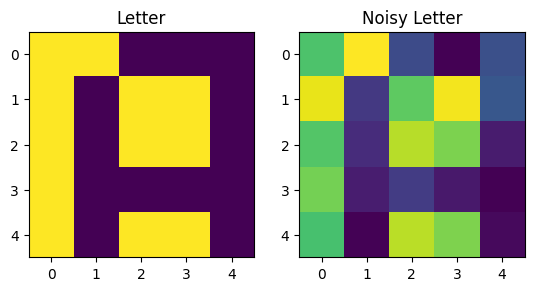

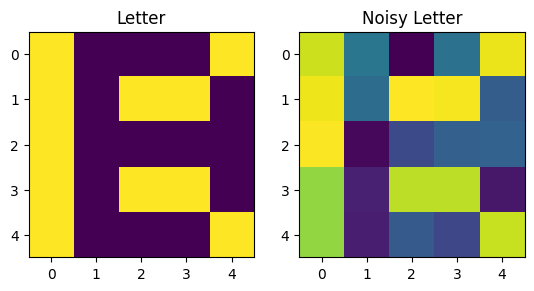

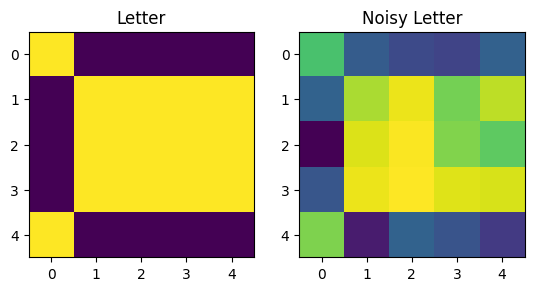

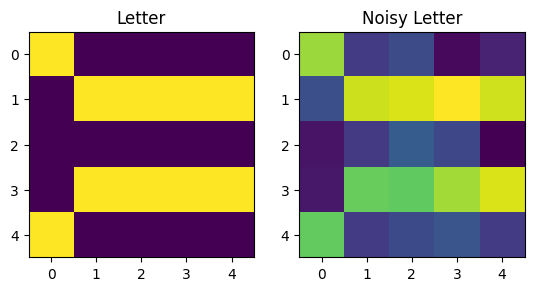

In [310]:
for sample, noise in zip(data_s, data_sn):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(sample.reshape((5, 5)))
    ax1.set_title('Letter')
    ax2.imshow(noise.reshape((5, 5)))
    ax2.set_title('Noisy Letter')
    plt.show()

## Recover patterns from noisy pictures

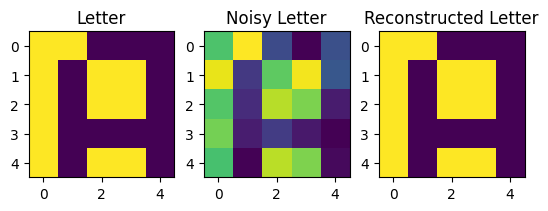

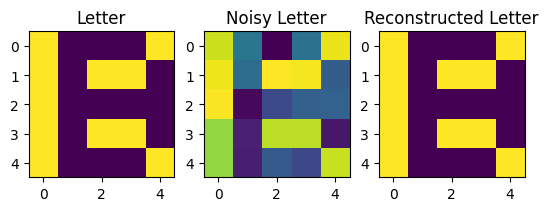

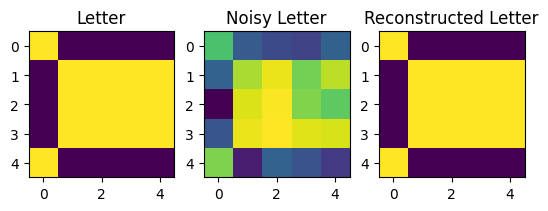

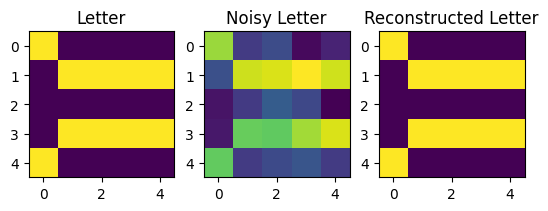

In [311]:
# Train the network on three patterns
hopfield_net = HopfieldNetwork(data_s.shape[-1])
hopfield_net.train(data_s)
for sample, noise in zip(data_s, data_sn):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    recalled_pattern = hopfield_net.recall(noise.copy(), max_iterations=1000)
    ax1.imshow(sample.reshape((5, 5)))
    ax1.set_title('Letter')
    ax2.imshow(noise.reshape((5, 5)))
    ax2.set_title('Noisy Letter')
    ax3.imshow(recalled_pattern.reshape((5, 5)))
    ax3.set_title('Reconstructed Letter')
    plt.show()

## Recover patterns from unknown pictures

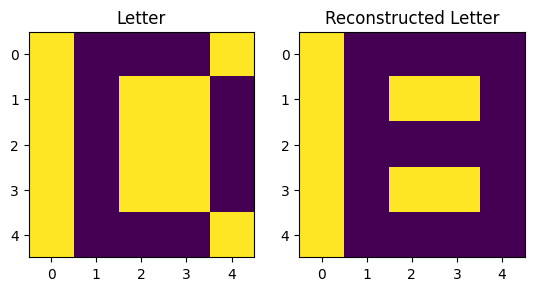

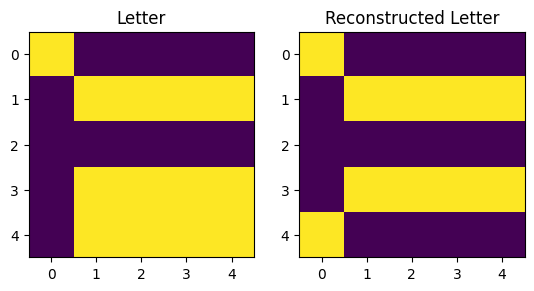

In [312]:
for sample in data_t:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    recalled_pattern = hopfield_net.recall(sample.copy(), max_iterations=1000)
    ax1.imshow(sample.reshape((5, 5)))
    ax1.set_title('Letter')
    ax2.imshow(recalled_pattern.reshape((5, 5)))
    ax2.set_title('Reconstructed Letter')
    plt.show()

# Task 3

In [334]:
# Constants
R = 8.314  # J/mol*K
T = 310  # K
F = 96485  # Coulombs/mol

# Calculate Nernst potential for K+
E_K = (R*T)/(1*F) * np.log(20e-3/430e-3)
print(f'Nernst potential for K+: {E_K:.2f} mV')

# Calculate Nernst potential for Na+
E_Na = (R*T)/(1*F) * np.log(440e-3/50e-3)
print(f'Nernst potential for Na+: {E_Na:.2f} mV')

# Calculate Nernst potential for Cl-
E_Cl = (R*T)/(-1*F) * np.log(560e-3/65e-3)
print(f'Nernst potential for Cl-: {E_Cl:.2f} mV')

Nernst potential for K+: -0.08 mV
Nernst potential for Na+: 0.06 mV
Nernst potential for Cl-: -0.06 mV


# Task 4

## Create function to simulate neuronal dynamics of 1 neuron

>The model can be described with the following equations:

>> v' = 0.04v2 + 5v + 140 - u + I

>> u' = a(bv - u)

>> v <- c, u <- u + d; if v >= 30

> * The parameter **a** describes the time scale of the recovery variable u.
> * The parameter **b** describes the sensitivity of the recovery variable u to the subthreshold fluctuations of the membrane potential v.
> * The parameter **c** describes the after-spike reset value of the membrane potential v caused by the fast high-threshold K+ conductances.
> * The parameter **d** describes after-spike reset of the recovery variable u caused by slow high-threshold Na+ and K+ conductances

In [3]:
NeuronalParameters = namedtuple('NeuronalParameters', 'a b c d I')


def simulate_neuron(num_steps: int, dt: float, params: NeuronalParameters) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate the membrane potential and recovery variable of a neuron.

    :param num_steps: The number of time steps to simulate.
    :param dt: The time step size.
    :param params: The parameters of the neuron.
    :return: A tuple containing the simulated values of the membrane potential and recovery variable.
    """
    # Initialize the membrane potential and recovery variable
    v = params.c
    u = params.b * v

    # Create arrays to store the simulated values of v and u
    v_values = np.empty(num_steps)
    u_values = np.empty(num_steps)

    # Iterate over the time steps
    for i in range(num_steps):
        # Compute the injected current

        # Update the membrane potential and recovery variable
        v_new = v + dt * (0.04 * v**2 + 5 * v + 140 - u + params.I)
        u_new = u + dt * params.a * (params.b * v - u)

        # Check if the recovery variable has reached the threshold
        if v_new >= 30:
            # Reset the membrane potential and recovery variable
            v_new = params.c
            u_new = u_new + params.d

        # Store the values of v and u for this time step
        v_values[i] = v
        u_values[i] = u

        # Update the values of v and u for the next time step
        v = v_new
        u = u_new

    return v_values, u_values


## Simulate chattering neuron (CH)

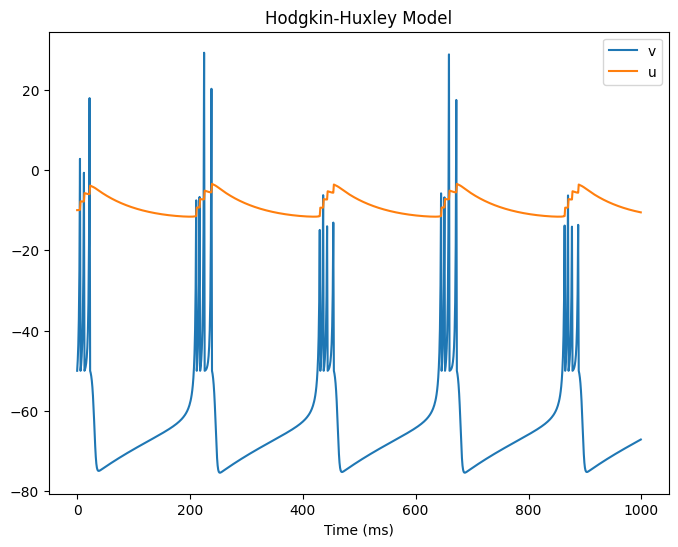

In [3]:
# Define the constants for the model
a = 0.02
b = 0.2
c = -50
d = 2
I = 5

# Define the time step and number of steps to simulate
dt = 0.5
num_steps = 1000

v_values, u_values = simulate_neuron(
    num_steps, dt,
    NeuronalParameters(a, b, c, d, I)
)


# Create a figure and set the size
fig = plt.figure(figsize=(8, 6))

# Create a subplot and set the title
ax = fig.add_subplot(111, title='Hodgkin-Huxley Model')

# Plot the values of v and u
ax.plot(v_values, label='v')
ax.plot(u_values, label='u')

# Set the x-axis label
ax.set_xlabel('Time (ms)')

# Add a legend
ax.legend()
# ax.set_xlim(700, 800)

# Show the plot
plt.show()

## Create function to simulate neuronal dynamics of a network

### Create function to make Erdős–Rényi graph

In [4]:
def create_erdos_renyi_graph(num_nodes: int, p: float):
    """
    Create an Erdős-Rényi graph with the given number of nodes and probability of edge creation.

    Parameters:
    num_nodes (int): The number of nodes in the graph.
    p (float): The probability of creating an edge between any two nodes.

    Returns:
    adjacency_matrix (numpy.ndarray): The adjacency matrix representing the graph.
    """
    # Create an empty adjacency matrix
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Iterate over all pairs of nodes
    for i in range(num_nodes):
        for j in range(num_nodes):
            # If the nodes are not the same and a random value is less than p, create an edge between them
            if i != j and random.uniform(0, 1) < p:
                adjacency_matrix[i, j] = 1

    return adjacency_matrix


### Create function to simulate network

In [5]:
def simulate_network(n_neurons: int, dt: float, n_times: int, connectivity: np.ndarray, params: NeuronalParameters) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Inputs:

        n_neurons (int): The number of neurons in the network.
        dt (float): The time step used in the simulation.
        n_times (int): The number of time steps to simulate.
        connectivity (np.ndarray): The connectivity matrix of the network.
        params (NeuronalParameters): An object with the following attributes:
            a (float): The time scale of the recovery variable u.
            b (float): The sensitivity of the recovery variable u to the subthreshold fluctuations of the membrane potential v.
            c (float): The after-spike reset value of the membrane potential v caused by the fast high-threshold K+ conductances.
            d (float): The after-spike reset of the recovery variable u caused by slow high-threshold Na+ and K+ conductances.
            I (float): The external current injected into each neuron.

    Outputs:

        v_course (np.ndarray): An array with the membrane potential of each neuron at each time step.
        u_course (np.ndarray): An array with the recovery variable of each neuron at each time step.
        spikes_array (np.ndarray): An array with the timesteps and neurons that spiked during the simulation.
    """

    # Setting values for a, b, c, and d
    re = np.random.rand(n_neurons)
    a = params.a * np.ones(n_neurons)
    b = params.b * np.ones(n_neurons)
    c = params.c * np.ones(n_neurons)
    d = params.d * np.ones(n_neurons)

    # Initial values for v and u
    v = c
    u = b * v

    v_course = np.zeros((n_neurons, n_times))
    u_course = v_course.copy()
    firings = list()

    # Simulation loop
    for t in range(n_times):  # simulation of 1000 ms
        # Thalamic input
        I = params.I * np.random.randn(n_neurons)

        # Indices of spikes
        fired = np.where(v >= 30)[0]

        # Store spike timings
        if fired.any():
            firings.append([t, fired])

        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        # Update v and u
        I = I + np.sum(connectivity[:, fired], axis=1)
        v = v + dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # step 0.5 ms
        v = v + dt * (0.04 * v**2 + 5 * v + 140 - u + I)  # for numerical stability
        u = u + a * (b * v - u)

        v_course[:, t] = v
        u_course[:, t] = u

    spikes_array = list()
    for t, spikes in firings:
        for spike in spikes:
            spikes_array.append([t, spike])

    return v_course, u_course, np.array(spikes_array)

### Create function to plot network parameters

In [7]:
def plot_network(
    v_course: np.ndarray,
    u_course: np.ndarray,
    spikes: np.ndarray,
    S: np.ndarray,
    title: str = '',
    figsize: tuple = (12.5, 10)
) -> plt.Figure:
    """
    Plot the network.

    Parameters
    ----------
    v_course : np.ndarray
        The membrane potential of all neurons over time.
    u_course : np.ndarray
        The membrane recovery variable of all neurons over time.
    spikes : np.ndarray
        The time and neuron number of all spikes.
    S : np.ndarray
        The synaptic weight matrix.
    title : str
        Title to the figure.
    figsize : tuple, optional
        The size of the figure, by default (12.5, 10)
    """
    G = nx.from_numpy_array(S)
    fig = plt.figure(constrained_layout=False)
    fig.suptitle(title)
    gs2 = fig.add_gridspec(
        nrows=10,
        ncols=10,
        wspace=.0,
        hspace=.0
    )
    ax1 = fig.add_subplot(gs2[:3, :5])
    ax2 = fig.add_subplot(gs2[3:, :5])
    ax3 = fig.add_subplot(gs2[:5, 5:])
    ax4 = fig.add_subplot(gs2[6:, 5:])
    ax1.plot(v_course.mean(0), c='tab:blue')
    ax1.plot(u_course.mean(0), c='tab:orange')
    ax1.legend(['v', 'u'])
    ax1.axes.xaxis.set_visible(False)
    ax1.set_ylabel('Amplotude (μV)')
    ax2.plot(spikes[:, 0], spikes[:, 1], '.', markersize=3, c='tab:gray')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Number of neuron')

    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)

    nx.draw(G, with_labels=False, node_size=10, ax=ax3)

    pos1 = ax4.get_position() # get the original position
    pos2 = [pos1.x0 + 0.05, pos1.y0 + .087/2,  pos1.width - .05, pos1.height - .01]
    ax4.set_position(pos2)

    sns.heatmap(S, ax=ax4, cbar=False)
    ax4.invert_yaxis()

    fig.set_size_inches(12.5, 10)
    return fig



## Visualize simulation of spiking neural network with 1000 CH neurons

### 1000 neurons with synapse probability p = 0.01 and p = 0.4

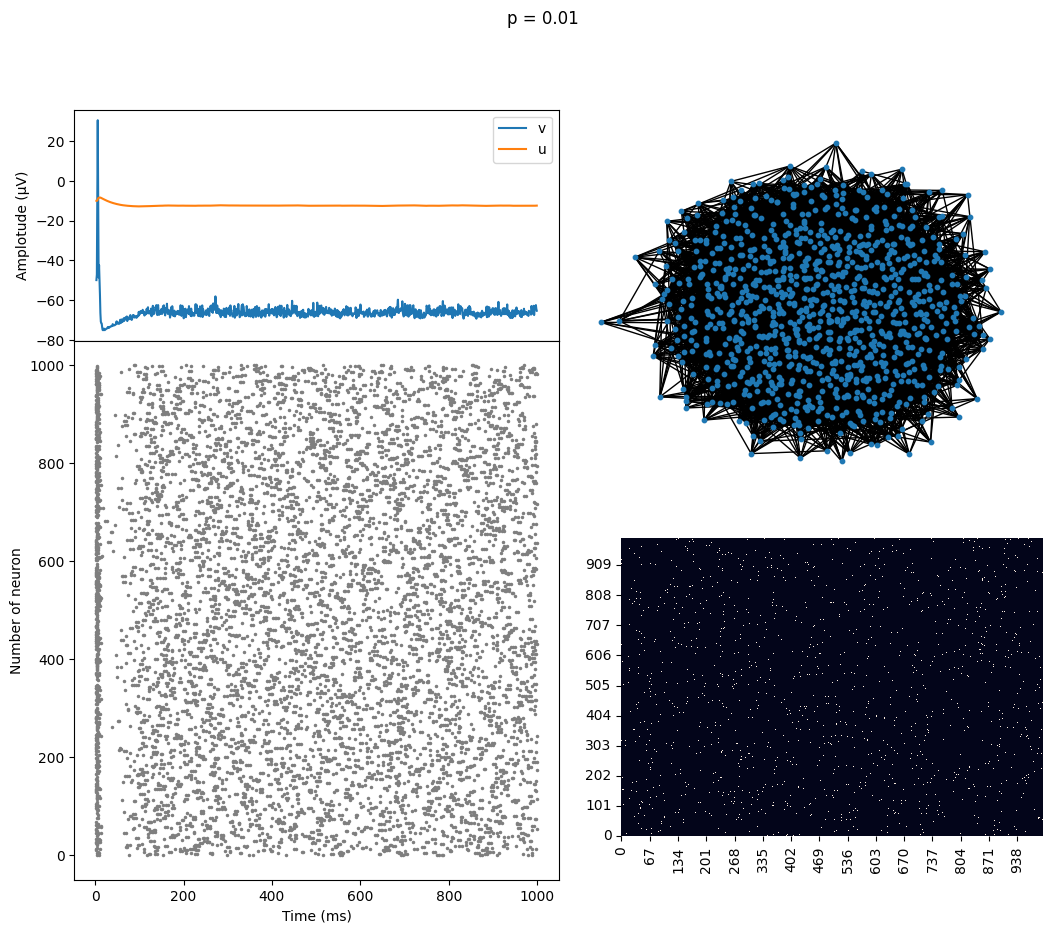

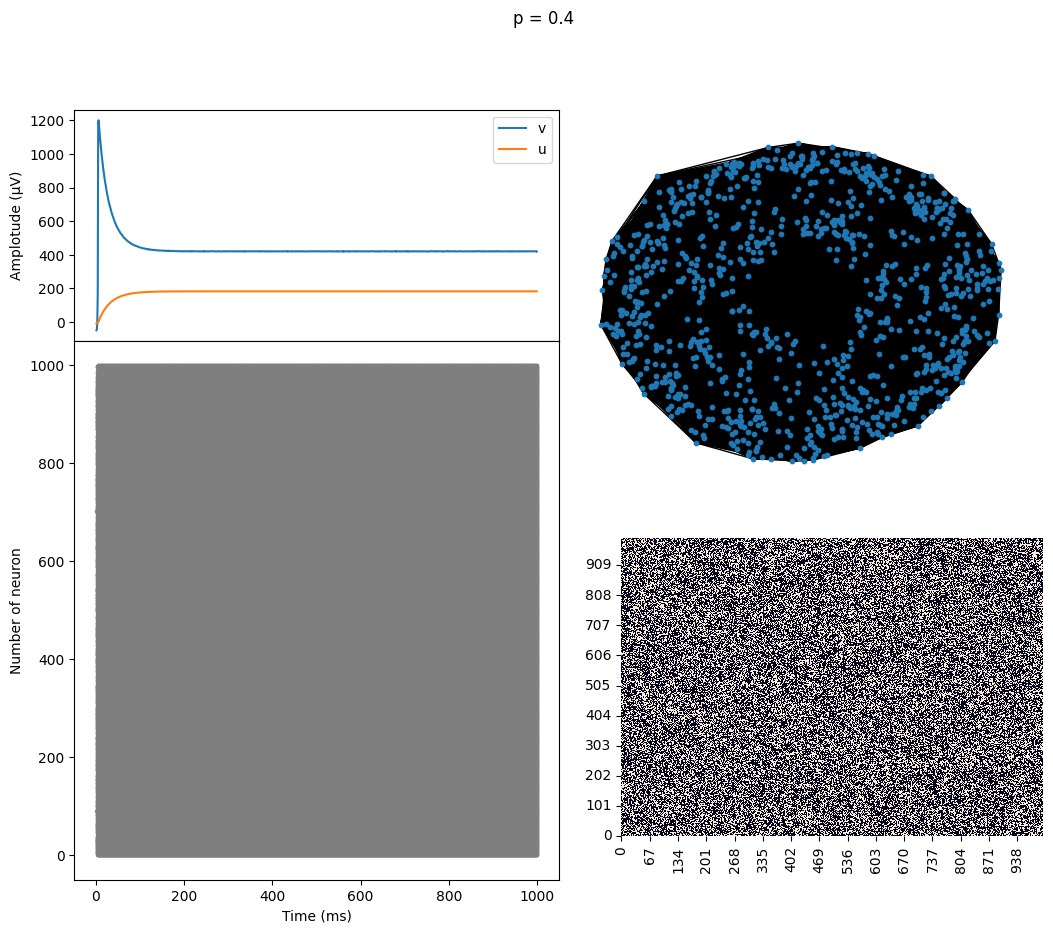

In [20]:
n_neurons = 1000
dt = .5
n_times = 1000
for p in [.01, .4]:
    S = create_erdos_renyi_graph(n_neurons, p)

    _ = plot_network(
        *simulate_network(n_neurons, dt, n_times, S, NeuronalParameters(a=0.02, b=0.2, c=-50, d=2, I=5)),
        S,
        title=f'{p = }'
    )
    plt.show()

### We see that connections are too weak for p=0.05 and too strong for p=0.4. We can regulate them

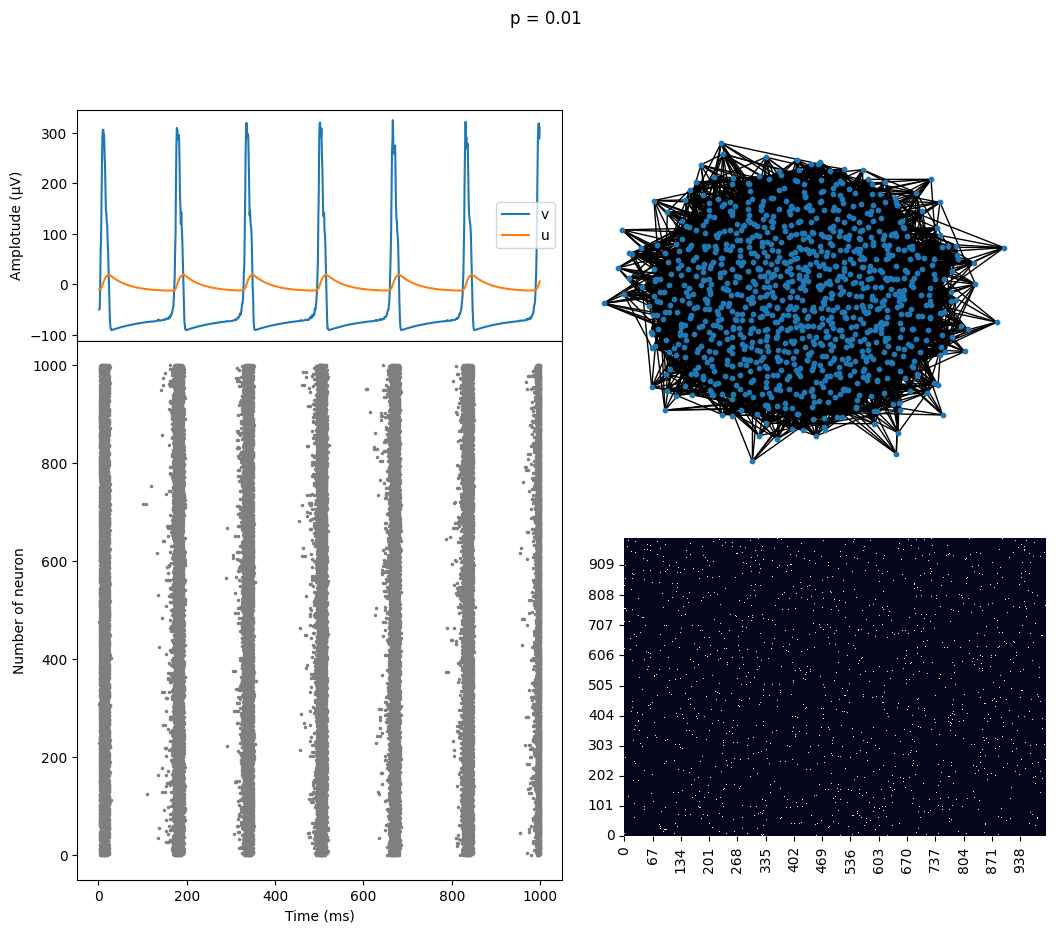

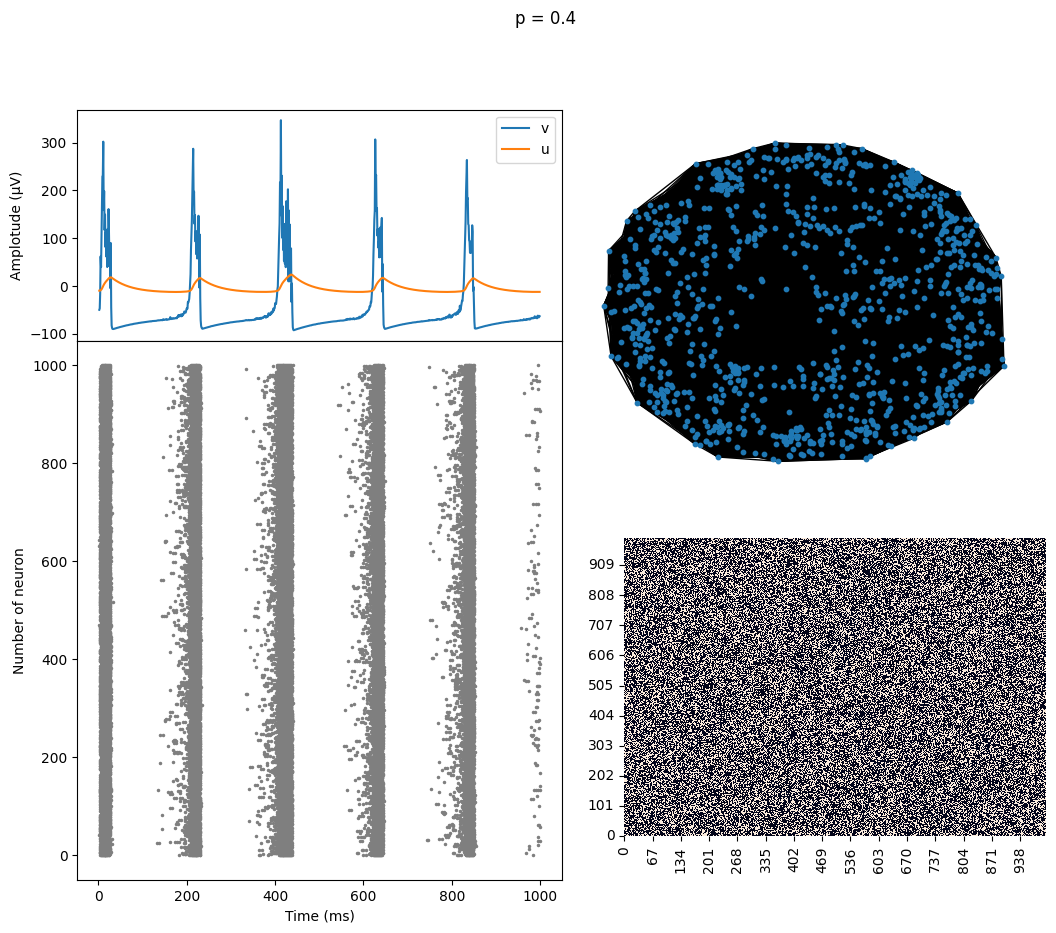

In [12]:
n_neurons = 1000
dt = .5
n_times = 1000
for p, s in zip([.01, .4], [10, .2]): # s responsible for the strength of synaptic connections. The more connections we have, the weaker they have to be
    S = create_erdos_renyi_graph(n_neurons, p)

    _ = plot_network(
        *simulate_network(n_neurons, dt, n_times, s*S, NeuronalParameters(a=0.02, b=0.2, c=-50, d=2, I=5)),
        S,
        title=f'{p = }'
    )
    plt.show()

### The same with 500 neurons

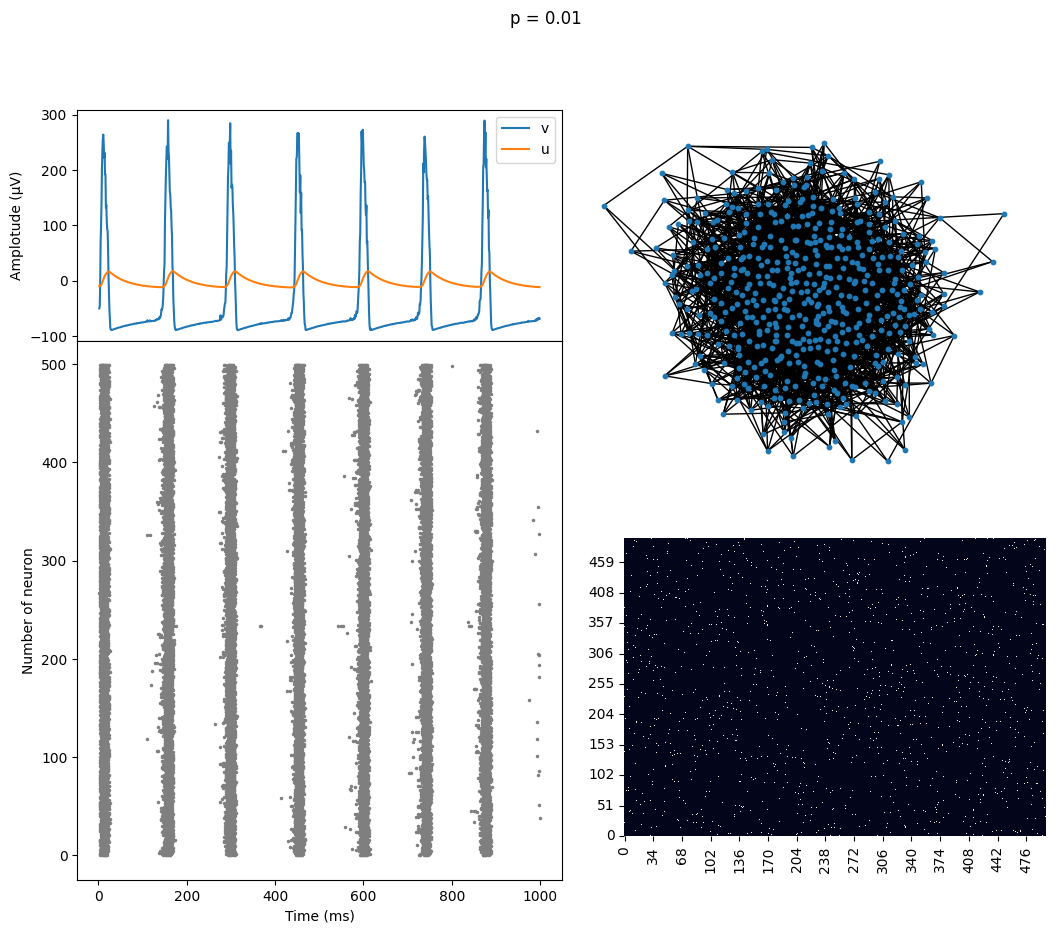

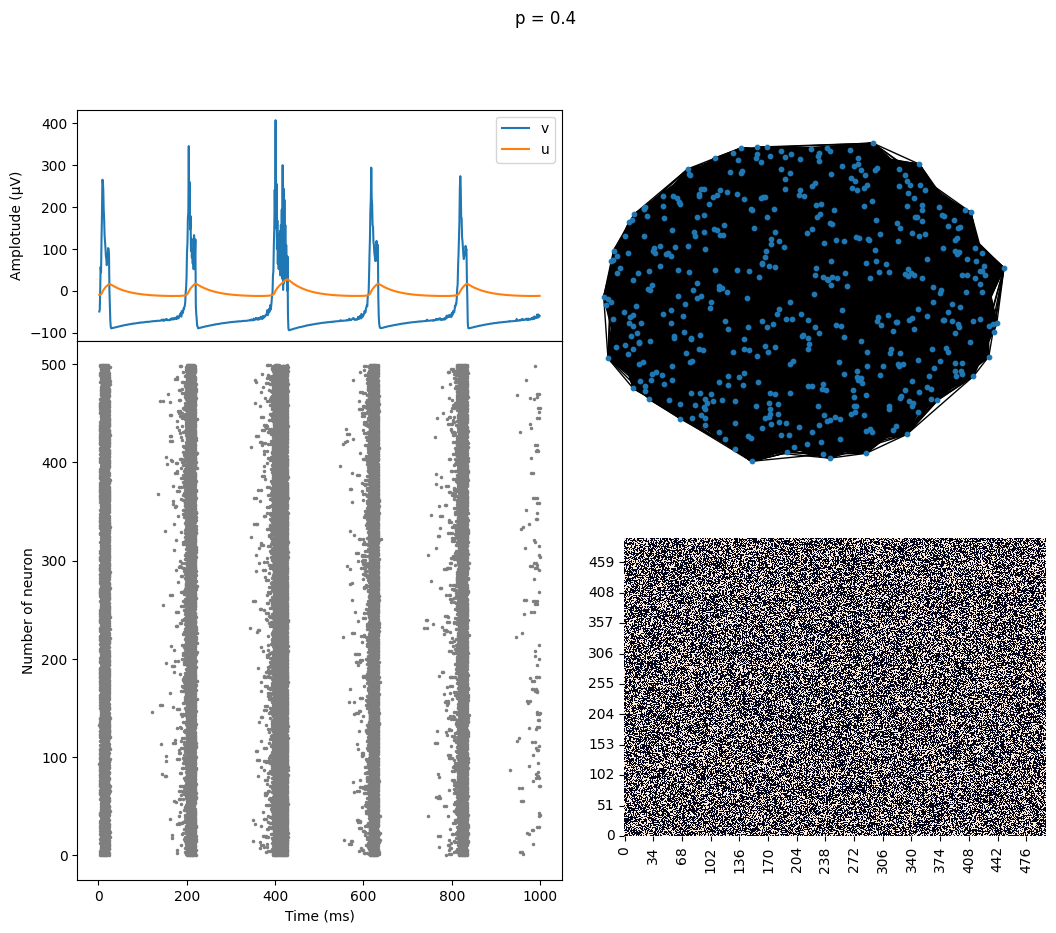

In [29]:
n_neurons = 500
dt = .5
n_times = 1000
for p, s in zip([.01, .4], [20, .4]):
    S = create_erdos_renyi_graph(n_neurons, p)

    _ = plot_network(
        *simulate_network(n_neurons, dt, n_times, s*S, NeuronalParameters(a=0.02, b=0.2, c=-50, d=2, I=5)),
        S,
        title=f'{p = }'
    )
    plt.show()

### The same with 2000 neurons

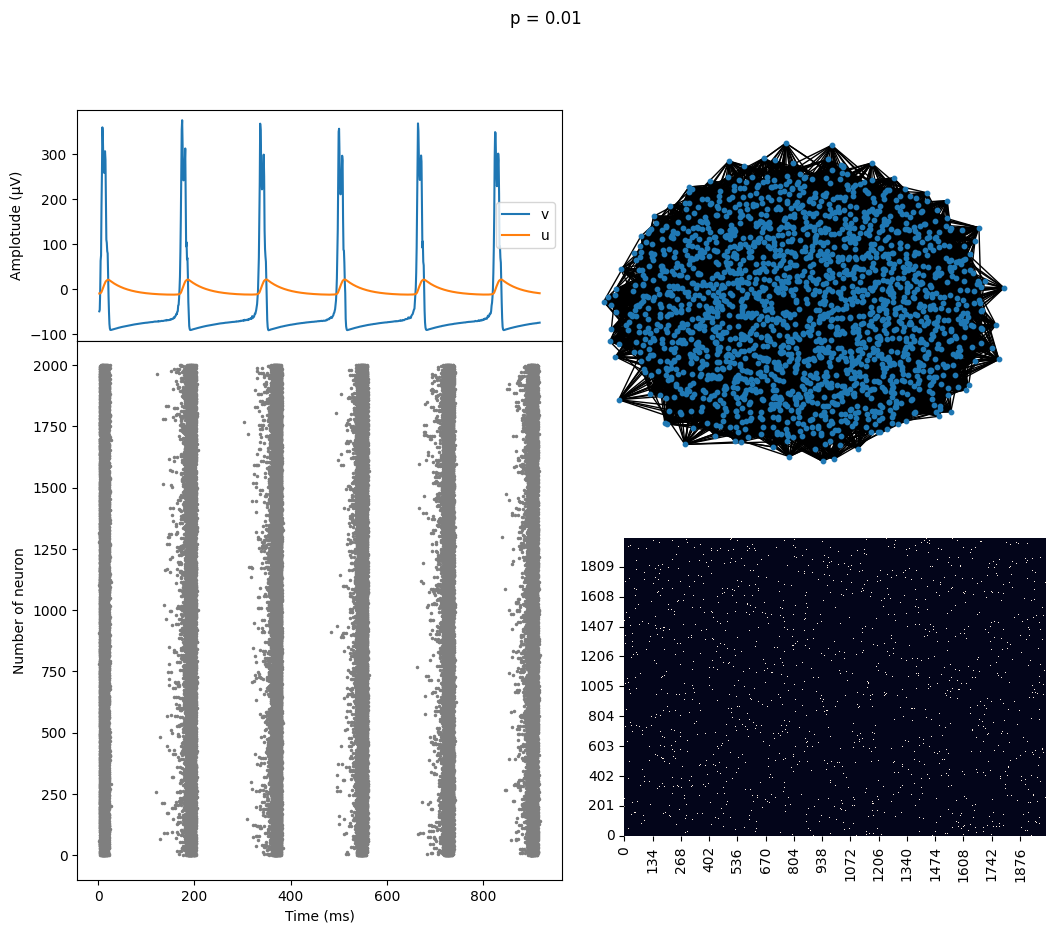

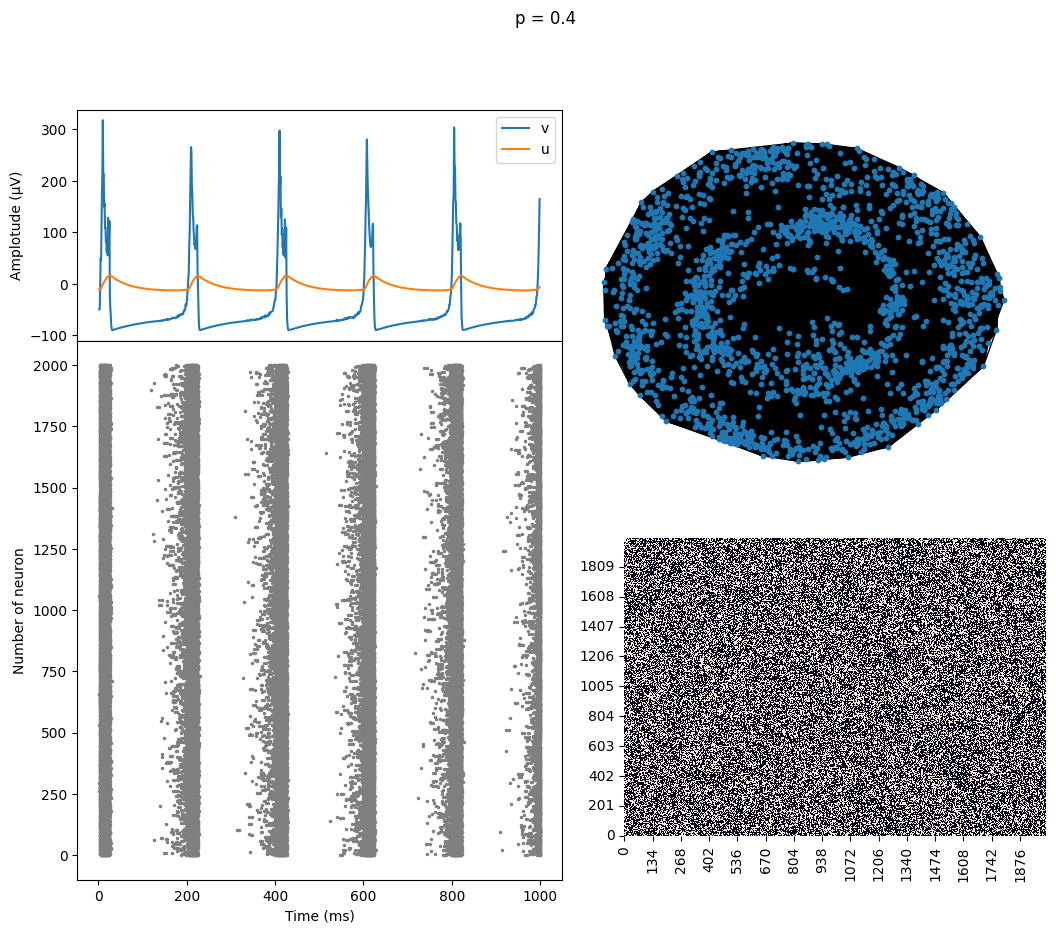

In [36]:
n_neurons = 2000
dt = .5
n_times = 1000
for p, s in zip([.01, .4], [5, .1]):
    S = create_erdos_renyi_graph(n_neurons, p)

    _ = plot_network(
        *simulate_network(n_neurons, dt, n_times, s*S, NeuronalParameters(a=0.02, b=0.2, c=-50, d=2, I=5)),
        S,
        title=f'{p = }'
    )
    plt.show()